In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# from lightgbm import LGBMClassifier
import xgboost as xgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('modeling_data1.csv') 
pd.set_option('display.max_columns', None)

data.head()

,Unnamed: 0,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,event_cutoff_by,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,SHIPPING_CONDITIONS,TIMEZONE,ABANDONED_CART,add_to_cart_before_event_cutoff_count,remove_from_cart_before_event_cutoff_count,duration_min_max_event_by_cutoff_minutes,mode_event_day,mode_event_month,mode_event_dow,device_event_device,mode_event_mobile_brand,mode_event_os,minutes_of_first_event_and_window_end,cutoff_amount,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order
0,0,500245685,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-23 11:02:29.219700000,G111,48 Hours,Monday,7,OFS,5:00:00 PM,48,America/Denver,1.0,1,5,67.003417,20,2,Thursday,desktop,Google,Windows,5924.706600,1777.411980,7,5,0,0,1,0,0
1,1,500245685,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-22 19:49:23.863200000,G111,48 Hours,Monday,7,OFS,5:00:00 PM,48,America/Denver,1.0,1,0,1.196567,18,3,Tuesday,desktop,Google,Windows,9034.144367,2710.243310,2,0,0,0,0,0,0
2,2,500245685,2025-04-14 17:00:00,2025-04-21 17:00:00,2025-04-20 11:20:52.683900000,G111,48 Hours,Monday,7,OFS,5:00:00 PM,48,America/Denver,1.0,1,1,3.350033,17,4,Thursday,desktop,Google,Windows,5927.056417,1778.116925,3,1,0,0,1,0,0
3,3,500245685,2025-04-28 17:00:00,2025-05-05 17:00:00,2025-05-04 18:24:35.996400000,G111,48 Hours,Monday,7,OFS,5:00:00 PM,48,America/Denver,1.0,1,0,10.874233,2,5,Friday,desktop,Google,Windows,4507.125967,1352.137790,2,0,0,0,0,0,0
4,4,500245738,2024-11-20 17:00:00,2024-11-27 17:00:00,2024-11-26 03:25:05.337600000,G111,48 Hours,Wednesday,7,OFS,5:00:00 PM,48,America/Denver,0.0,1,0,1.244100,22,11,Friday,desktop,Microsoft,Windows,7515.126033,2254.537810,2,0,0,1,0,0,1


In [3]:
data.columns

Index(['Unnamed: 0', 'CUSTOMER_ID', 'WINDOW_START_LOCAL', 'WINDOW_END_LOCAL',
       'event_cutoff_by', 'SALES_OFFICE', 'SHIPPING_CONDITIONS_DESC',
       'WEEK_DAY_OF_ANCHOR_DATE', 'WINDOW_FREQUENCY', 'DISTRIBUTION_MODE_DESC',
       'CUTOFFTIME__C', 'SHIPPING_CONDITIONS', 'TIMEZONE', 'ABANDONED_CART',
       'add_to_cart_before_event_cutoff_count',
       'remove_from_cart_before_event_cutoff_count',
       'duration_min_max_event_by_cutoff_minutes', 'mode_event_day',
       'mode_event_month', 'mode_event_dow', 'device_event_device',
       'mode_event_mobile_brand', 'mode_event_os',
       'minutes_of_first_event_and_window_end', 'cutoff_amount',
       'total_events', 'cart_page_views', 'product_page_views',
       'order_page_views', 'visited_cart', 'visited_product', 'visited_order'],
      dtype='object')

In [4]:
x = data.drop(columns=['ABANDONED_CART','CUSTOMER_ID', 'Unnamed: 0'])
y = data['ABANDONED_CART']

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.3,
    random_state=12345,
    stratify=y 
)

# xgboost

In [5]:
# ===== PREP for XGBoost WITHOUT one-hot encoding =====
# Assumes you already have: x_train, x_test, y_train, y_test
import pandas as pd
import numpy as np

def prep_for_xgb_no_ohe(X_tr: pd.DataFrame, X_te: pd.DataFrame):
    train = X_tr.copy()
    test  = X_te.copy()

    # 0) Drop any leftover "Unnamed:*" columns (from CSV index)
    train = train.loc[:, ~train.columns.str.contains(r"^Unnamed")]
    test  = test.loc[:,  ~test.columns.str.contains(r"^Unnamed")]

    # 1) Parse known datetime-like columns (add any others you have)
    dt_known = ["WINDOW_START_LOCAL","WINDOW_END_LOCAL","EVENT_LOCAL_DT","EVENT_LOCAL_NAIVE","event_cutoff_by"]
    dt_cols = [c for c in dt_known if c in train.columns]

    for c in dt_cols:
        # parse as datetime; keep tz-awareness consistent
        train[c] = pd.to_datetime(train[c], errors="coerce", utc=True)
        test[c]  = pd.to_datetime(test[c],  errors="coerce", utc=True)

    # expand datetimes into year/month/day/time_seconds
    def add_ymdt(df, cols):
        for c in cols:
            ser = df[c]
            # make naive for component extraction
            ser = ser.dt.tz_convert(None)
            df[f"{c}_year"]  = ser.dt.year.astype("Int32")
            df[f"{c}_month"] = ser.dt.month.astype("Int8")
            df[f"{c}_day"]   = ser.dt.day.astype("Int8")
            df[f"{c}_time_seconds"] = (ser.dt.hour*3600 + ser.dt.minute*60 + ser.dt.second).astype("Float64")
        return df

    train = add_ymdt(train, dt_cols) if dt_cols else train
    test  = add_ymdt(test,  dt_cols) if dt_cols else test

    # drop the raw datetime stamps
    train.drop(columns=[c for c in dt_cols if c in train.columns], inplace=True)
    test.drop(columns=[c for c in dt_cols if c in test.columns], inplace=True)

    # 2) Convert specific time strings to numeric (avoid high-cardinality dummies)
    if "CUTOFFTIME__C" in train.columns:
        # robust parse to time -> minutes since midnight
        def time_to_minutes(s):
            t = pd.to_datetime(s, errors="coerce").dt.time
            return (pd.Series(t).apply(lambda x: (x.hour*60 + x.minute) if pd.notna(x) else np.nan)).values
        train["CUTOFFTIME__C_minutes"] = time_to_minutes(train["CUTOFFTIME__C"])
        test["CUTOFFTIME__C_minutes"]  = time_to_minutes(test["CUTOFFTIME__C"])
        train.drop(columns=["CUTOFFTIME__C"], inplace=True)
        test.drop(columns=["CUTOFFTIME__C"], inplace=True)

    # 3) Timedelta -> seconds
    td_cols = sorted(set(train.select_dtypes(include="timedelta64[ns]").columns) |
                     set(test.select_dtypes(include="timedelta64[ns]").columns))
    for c in td_cols:
        if c in train: train[c] = pd.to_timedelta(train[c]).dt.total_seconds().astype("Float64")
        if c in test:  test[c]  = pd.to_timedelta(test[c]).dt.total_seconds().astype("Float64")

    # 4) Booleans -> small ints (optional; XGB can take bools, but keep numeric-clean)
    for df in (train, test):
        for c in df.select_dtypes(include="bool").columns:
            df[c] = df[c].astype("Int8")

    # 5) Handle remaining object columns AS CATEGORICAL (no one-hot)
    obj_tr = train.select_dtypes(include="object").columns.tolist()
    obj_te = test.select_dtypes(include="object").columns.tolist()
    obj_cols = sorted(set(obj_tr) | set(obj_te))

    for c in obj_cols:
        # cast to category on both, align category universe
        tr_cat = train[c].astype("category") if c in train.columns else None
        te_cat = test[c].astype("category")  if c in test.columns  else None

        cats = pd.Index([])
        if tr_cat is not None: cats = cats.union(tr_cat.astype("category").cat.categories)
        if te_cat is not None: cats = cats.union(te_cat.astype("category").cat.categories)

        # add explicit Missing category so we don't lose rows
        cats = cats.insert(len(cats), "__MISSING__") if "__MISSING__" not in cats else cats

        if tr_cat is not None:
            train[c] = train[c].astype("category")
            train[c] = train[c].cat.add_categories(["__MISSING__"]).fillna("__MISSING__")
            train[c] = train[c].cat.set_categories(cats)

        if te_cat is not None:
            test[c] = test[c].astype("category")
            test[c] = test[c].cat.add_categories(["__MISSING__"]).fillna("__MISSING__")
            test[c] = test[c].cat.set_categories(cats)

    # 6) Numeric impute (leave categoricals as-is; XGB handles missing)
    num_cols = train.select_dtypes(include=[np.number]).columns
    med = train[num_cols].median()
    train[num_cols] = train[num_cols].fillna(med)
    test[num_cols]  = test[num_cols].fillna(med)

    return train, test

# ---- use it
train_prep, test_prep = prep_for_xgb_no_ohe(x_train, x_test)
print(train_prep.dtypes.value_counts())  # you'll see float/int and 'category', not booleans nor OHE


int64       14
Int8         6
float64      3
Int32        3
Float64      3
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
Name: count, dtype: int64


/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_48733/2563096621.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(s, errors="coerce").dt.time
/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_48733/2563096621.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(s, errors="coerce").dt.time


In [6]:
import xgboost as xgb

# IMPORTANT: enable_categorical=True and keep tree_method='hist'
params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "eta": 0.035,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "scale_pos_weight": float((y_train==0).sum())/max((y_train==1).sum(),1),
    "tree_method": "hist",
    "enable_categorical": True,
    "seed": 42,
}

# Pass pandas DataFrames (with category dtypes) directly
dtrain = xgb.DMatrix(train_prep, label=y_train.values, enable_categorical=True)
dvalid = xgb.DMatrix(test_prep,  label=y_test.values,  enable_categorical=True)

early_cb = xgb.callback.EarlyStopping(rounds=80, save_best=True, metric_name="aucpr")
bst = xgb.train(params, dtrain, num_boost_round=2000,
                evals=[(dtrain,"train"), (dvalid,"valid")],
                callbacks=[early_cb], verbose_eval=False)




/opt/anaconda3/envs/msba/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [16:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "enable_categorical" } are not used.

  self.starting_round = model.num_boosted_rounds()


✅ Feasible model found!

Config: {'spw_mult': 2.0, 'max_depth': 8, 'eta': 0.025}
Threshold: 0.070
Accuracy : 0.818
Recall   : 0.712
Precision: 0.420
F1-score : 0.528

Confusion Matrix:
 [[3976  783]
 [ 229  567]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.84      0.89      4759
         1.0       0.42      0.71      0.53       796

    accuracy                           0.82      5555
   macro avg       0.68      0.77      0.71      5555
weighted avg       0.87      0.82      0.84      5555


Top 20 features by gain:
                                        feature      gain
0                          SHIPPING_CONDITIONS  9.570239
1                                 total_events  9.252152
2   remove_from_cart_before_event_cutoff_count  8.727736
3                                 SALES_OFFICE  8.001470
4                     SHIPPING_CONDITIONS_DESC  7.904253
5        add_to_cart_before_event_cutoff_count  7.533025
6        

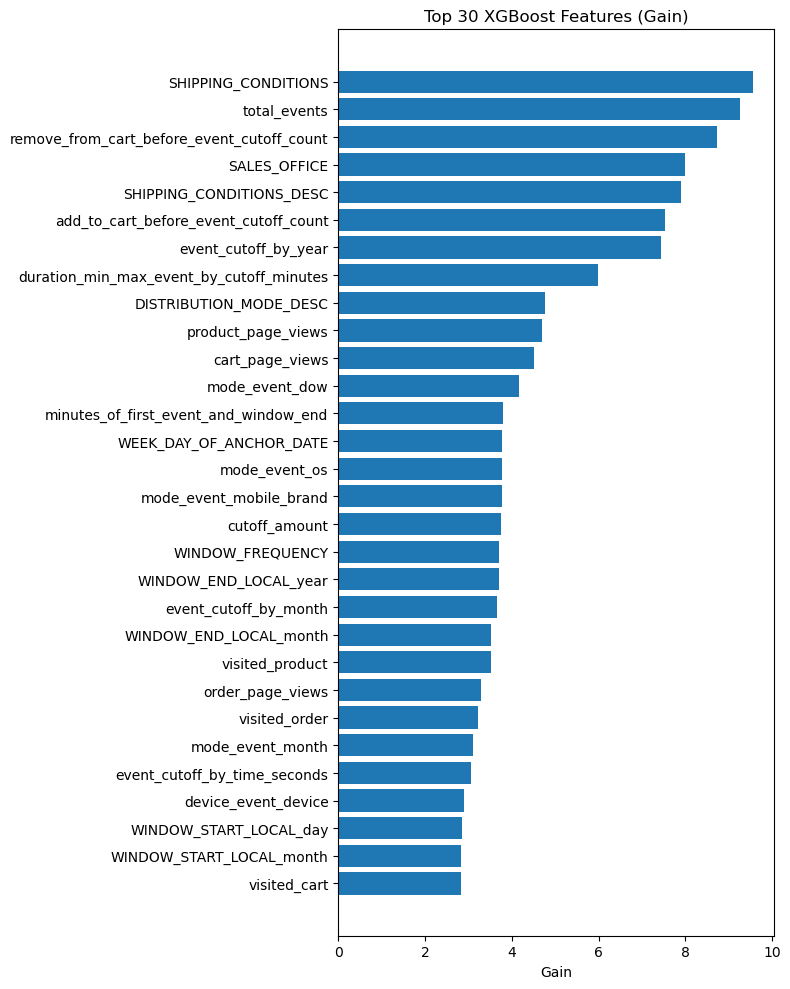

In [7]:
# ==== TRAIN XGBOOST, SELECT BEST MODEL, AND SHOW METRICS + IMPORTANCE ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

ACC_MIN = 0.80
REC_MIN = 0.70
TH_GRID = np.linspace(0.01, 0.99, 197)

def train_and_select_best(train_df, y_tr, test_df, y_te,
                          configs=None, rounds=2500, es_rounds=120):
    if configs is None:
        configs = [
            {"spw_mult": 2.0, "max_depth": 8, "eta": 0.025},
            {"spw_mult": 2.5, "max_depth": 8, "eta": 0.025},
            {"spw_mult": 3.0, "max_depth": 9, "eta": 0.020},
            {"spw_mult": 1.8, "max_depth": 7, "eta": 0.030},
        ]

    dtr = xgb.DMatrix(train_df, label=y_tr.values, enable_categorical=True)
    dve = xgb.DMatrix(test_df,  label=y_te.values,  enable_categorical=True)
    spw_base = float((y_tr == 0).sum()) / max(float((y_tr == 1).sum()), 1)

    best_feasible, best_infeasible = None, None

    for cfg in configs:
        params = {
            "objective": "binary:logistic",
            "eval_metric": "aucpr",
            "tree_method": "hist",
            "max_depth": cfg["max_depth"],
            "learning_rate": cfg["eta"],
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "scale_pos_weight": spw_base * cfg["spw_mult"],
            "max_delta_step": 1,
            "seed": 42,
        }

        early_cb = xgb.callback.EarlyStopping(rounds=es_rounds, save_best=True, metric_name="aucpr")
        bst = xgb.train(params, dtr, num_boost_round=rounds,
                        evals=[(dtr, "train"), (dve, "valid")],
                        callbacks=[early_cb], verbose_eval=False)

        bi = getattr(bst, "best_iteration", None)
        y_prob = bst.predict(dve, iteration_range=(0, bi + 1)) if bi is not None else bst.predict(dve)

        for th in TH_GRID:
            yp = (y_prob >= th).astype(int)
            acc = accuracy_score(y_te, yp)
            rec = recall_score(y_te, yp, zero_division=0)
            prec = precision_score(y_te, yp, zero_division=0)
            f1 = f1_score(y_te, yp, zero_division=0)

            if acc >= ACC_MIN and rec >= REC_MIN:
                score = acc + rec
                if (best_feasible is None) or (score > best_feasible["score"]):
                    best_feasible = {
                        "cfg": cfg, "bst": bst, "th": th,
                        "acc": acc, "rec": rec, "prec": prec, "f1": f1,
                        "score": score, "cm": confusion_matrix(y_te, yp),
                        "y_prob": y_prob
                    }
            else:
                gap = (ACC_MIN - acc if acc < ACC_MIN else 0) + (REC_MIN - rec if rec < REC_MIN else 0)
                if (best_infeasible is None) or (gap < best_infeasible["gap"]):
                    best_infeasible = {
                        "cfg": cfg, "bst": bst, "th": th,
                        "acc": acc, "rec": rec, "prec": prec, "f1": f1,
                        "gap": gap, "cm": confusion_matrix(y_te, yp),
                        "y_prob": y_prob
                    }

    return best_feasible if best_feasible is not None else best_infeasible

# === RUN SEARCH ===
best = train_and_select_best(train_prep, y_train, test_prep, y_test)

# === REPORT ===
if "gap" in best:
    print("⚠️ No model met Acc≥0.80 & Recall≥0.70. Closest:")
else:
    print("✅ Feasible model found!")

print(f"\nConfig: {best['cfg']}")
print(f"Threshold: {best['th']:.3f}")
print(f"Accuracy : {best['acc']:.3f}")
print(f"Recall   : {best['rec']:.3f}")
print(f"Precision: {best['prec']:.3f}")
print(f"F1-score : {best['f1']:.3f}")

print("\nConfusion Matrix:\n", best["cm"])
print("\nClassification Report:\n",
      classification_report(y_test, (best["y_prob"] >= best["th"]).astype(int), zero_division=0))

# === FEATURE IMPORTANCE ===
fi = best["bst"].get_score(importance_type="gain")
fi_df = (pd.DataFrame({"feature": list(fi.keys()), "gain": list(fi.values())})
         .sort_values("gain", ascending=False)
         .reset_index(drop=True))

print("\nTop 20 features by gain:\n", fi_df.head(20))

plt.figure(figsize=(8, 10))
topn = min(30, len(fi_df))
plt.barh(fi_df["feature"].head(topn)[::-1], fi_df["gain"].head(topn)[::-1])
plt.title(f"Top {topn} XGBoost Features (Gain)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()


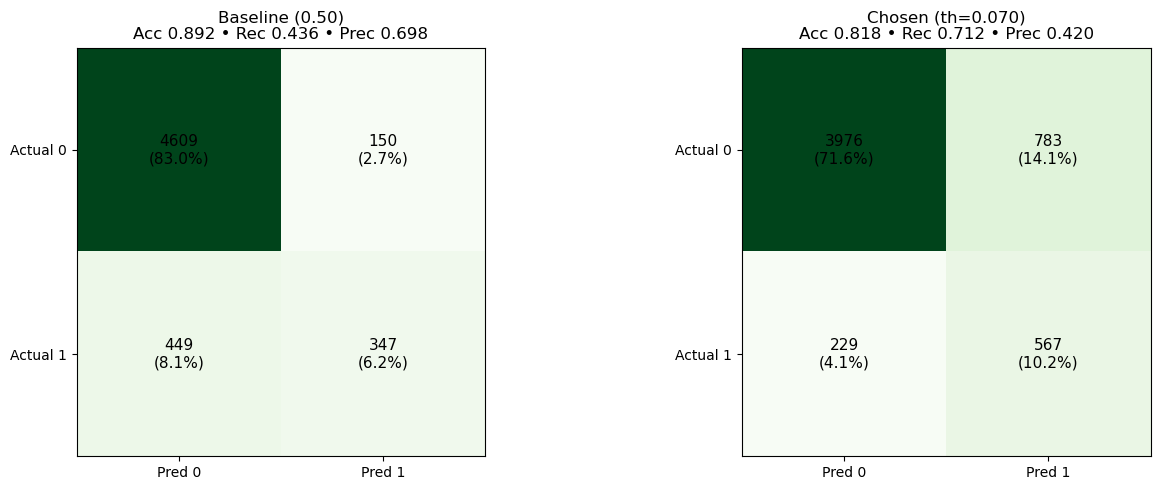

In [8]:
# === PLOTS: Confusion matrices (baseline 0.50 vs chosen) ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Baseline @0.50 using the same prob vector best["y_prob"]
y_pred_050 = (best["y_prob"] >= 0.50).astype(int)
acc_050 = accuracy_score(y_test, y_pred_050)
rec_050 = recall_score(y_test, y_pred_050, zero_division=0)
prec_050 = precision_score(y_test, y_pred_050, zero_division=0)
cm_050 = confusion_matrix(y_test, y_pred_050)

# Chosen operating point
y_pred_best = (best["y_prob"] >= best["th"]).astype(int)
acc_b = best["acc"]; rec_b = best["rec"]; prec_b = best["prec"]
cm_best = best["cm"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, cm, title, acc, rec, prec in [
    (axes[0], cm_050, "Baseline (0.50)", acc_050, rec_050, prec_050),
    (axes[1], cm_best, f"Chosen (th={best['th']:.3f})", acc_b, rec_b, prec_b),
]:
    cm_prop = cm / cm.sum()
    im = ax.imshow(cm, cmap="Greens")
    ax.set_title(f"{title}\nAcc {acc:.3f} • Rec {rec:.3f} • Prec {prec:.3f}")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0","Pred 1"]); ax.set_yticklabels(["Actual 0","Actual 1"])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm[i,j]}\n({cm_prop[i,j]:.1%})",
                    ha="center", va="center", fontsize=11)
plt.tight_layout()
plt.show()


# Sales?

In [10]:
sales = pd.read_csv('Copy of sales.csv')
sales.head()

,CUSTOMER_ID,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI,NSI_DEAD_NET,GROSS_PROFIT
0,501473438,2024-06-10,123159,53.60,8.0,111.04,111.04,53.60
1,501473438,2024-06-10,115584,21.76,4.0,51.12,51.12,21.76
2,501502460,2024-06-10,103996,-0.89,2.0,210.80,210.80,-0.89
3,501168843,2024-06-10,156091,10.20,2.0,30.50,30.50,10.20
4,501583464,2024-06-10,119827,42.15,4.0,98.40,88.40,52.15


/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_48733/2571047738.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_sales = agg.groupby('bucket', as_index=False)['SALES'].sum()


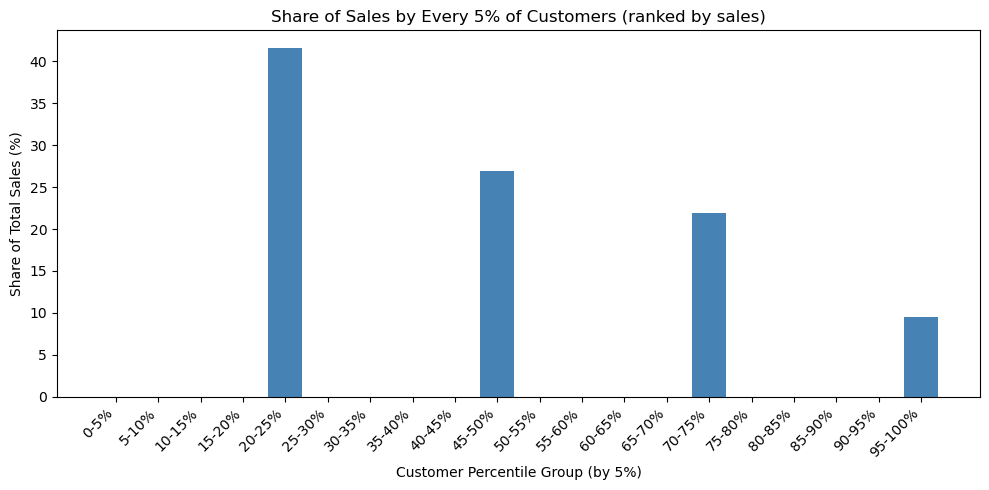

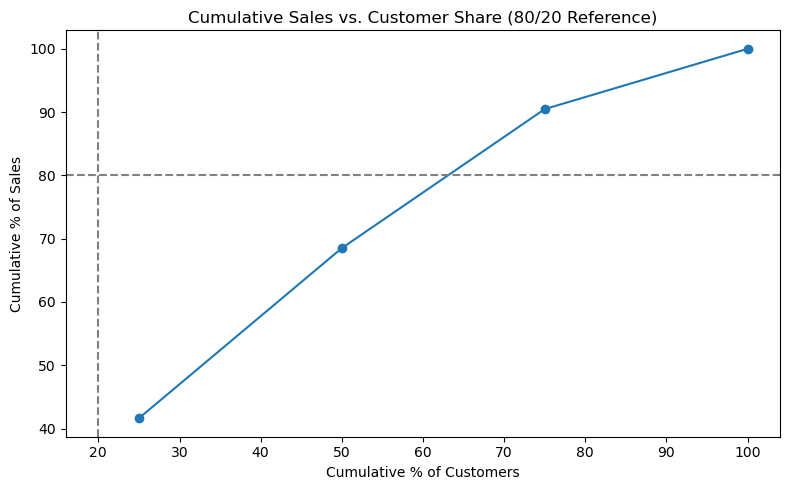

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== INPUT ====
# Replace `sales_df` with your real data frame that has columns:
#   CUSTOMER_ID, NSI_DEAD_NET (numeric)
try:
    sales_df
except NameError:
    sales_df = pd.DataFrame({
        'CUSTOMER_ID': [501473438, 501473438, 501502460, 501168843, 501583464,
                         501168843, 501583464, 501502460, 501168843, 501583464],
        'NSI_DEAD_NET': [111.04, 51.12, 210.80, 30.50, 88.40, 15.0, 25.2, 40.3, 12.0, 18.9]
    })

# ==== PREP: aggregate by customer ====
agg = (
    sales_df.groupby('CUSTOMER_ID', as_index=False)['NSI_DEAD_NET']
            .sum()
            .rename(columns={'NSI_DEAD_NET': 'SALES'})
)

# Sort DESC for cumulative calculations
agg = agg.sort_values('SALES', ascending=False).reset_index(drop=True)
agg['cust_cum_pct'] = (np.arange(1, len(agg) + 1)) / len(agg)
agg['sales_cum'] = agg['SALES'].cumsum()
agg['sales_cum_pct'] = agg['sales_cum'] / agg['SALES'].sum()

# ==== Divide into 5% buckets ====
agg['bucket'] = pd.cut(agg['cust_cum_pct'], bins=np.linspace(0,1,21), labels=[f'{i*5}-{(i+1)*5}%' for i in range(20)])

# Compute sales share per bucket
bucket_sales = agg.groupby('bucket', as_index=False)['SALES'].sum()
bucket_sales['share_pct'] = bucket_sales['SALES'] / bucket_sales['SALES'].sum() * 100

# ==== FIGURE 1: Sales share by 5% customer buckets ====
plt.figure(figsize=(10,5))
plt.bar(bucket_sales['bucket'].astype(str), bucket_sales['share_pct'], color='steelblue')
plt.title('Share of Sales by Every 5% of Customers (ranked by sales)')
plt.xlabel('Customer Percentile Group (by 5%)')
plt.ylabel('Share of Total Sales (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ==== FIGURE 2: Cumulative share line ====
plt.figure(figsize=(8,5))
plt.plot(agg['cust_cum_pct']*100, agg['sales_cum_pct']*100, marker='o')
plt.axhline(80, color='gray', linestyle='--')
plt.axvline(20, color='gray', linestyle='--')
plt.title('Cumulative Sales vs. Customer Share (80/20 Reference)')
plt.xlabel('Cumulative % of Customers')
plt.ylabel('Cumulative % of Sales')
plt.tight_layout()
plt.show()

# ==== Notes ====
# • Each bar shows the percentage of total sales contributed by each 5% slice of customers.
# • Use this to highlight concentration patterns more finely than deciles.
# • The second chart shows cumulative distribution with an 80/20 guide.


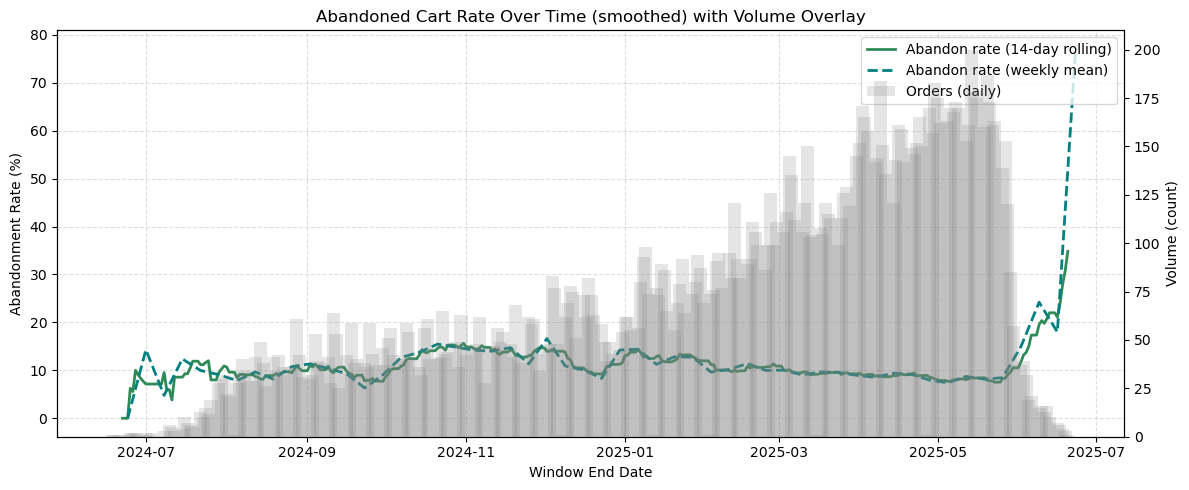

<Figure size 1000x400 with 0 Axes>

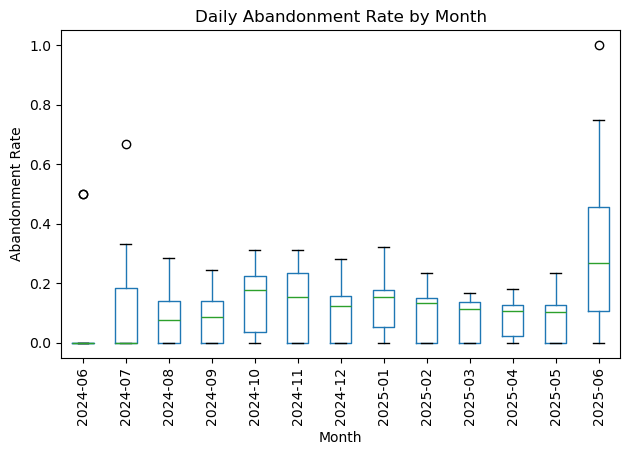

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Choose the date column that exists ---
date_col = None
for c in ["WINDOW_END_LOCAL", "WINDOW_END_LOCAL_event_cutoff", "WINDOW_END_LOCAL_dt"]:
    if c in data.columns:
        date_col = c
        break
assert date_col is not None, "No WINDOW_END_LOCAL-like column found."

df = data[[date_col, "ABANDONED_CART"]].copy()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

# --- Daily aggregates ---
daily = pd.DataFrame({
    "rate": df["ABANDONED_CART"].resample("D").mean(),     # abandonment rate per day
    "n":    df["ABANDONED_CART"].resample("D").size()      # volume per day
}).fillna(0)

# --- Smoothers / Resamples ---
daily["rate_roll14"] = daily["rate"].rolling(14, min_periods=5).mean()
weekly = daily.resample("W-MON").agg({"rate":"mean","n":"sum"}).rename(columns={"rate":"rate_week"})

# --- Plot: rate (left axis) + volume (right axis) ---
fig, ax1 = plt.subplots(figsize=(12,5))

# Volume bars (right axis)
ax2 = ax1.twinx()
ax2.bar(daily.index, daily["n"], width=5, alpha=0.20, color="gray", label="Orders (daily)")
ax2.set_ylabel("Volume (count)")

# Lines: 14-day rolling + weekly mean
ax1.plot(daily.index, daily["rate_roll14"]*100, lw=2, color="seagreen", label="Abandon rate (14-day rolling)")
ax1.plot(weekly.index, weekly["rate_week"]*100, lw=2, color="teal", linestyle="--", label="Abandon rate (weekly mean)")

ax1.set_title("Abandoned Cart Rate Over Time (smoothed) with Volume Overlay")
ax1.set_xlabel("Window End Date")
ax1.set_ylabel("Abandonment Rate (%)")
ax1.grid(True, linestyle="--", alpha=0.4)

# Legend (combine both axes)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")
plt.tight_layout()
plt.show()

# --- Optional: monthly boxplot to show seasonality/dispersion ---
monthly = daily.copy()
monthly["month"] = monthly.index.to_period("M").astype(str)

plt.figure(figsize=(10,4))
monthly.dropna(subset=["rate"]).boxplot(column="rate", by="month", grid=False, rot=0)
plt.title("Daily Abandonment Rate by Month"); plt.suptitle("")
plt.ylabel("Abandonment Rate"); plt.xlabel("Month")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

